In [4]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt

In [5]:

# Set random seed for reproducibility
tf.random.set_seed(42)

# Define parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 4
DATA_DIR = "D:/infrastructure"


In [6]:

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create training and validation generators
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)


Found 813 images belonging to 4 classes.


In [7]:
validation_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Create base model with DenseNet121 instead of MobileNetV2
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze the base model layers
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)


Found 201 images belonging to 4 classes.


In [10]:

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)


Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.7513 - loss: 0.5571 - val_accuracy: 0.5323 - val_loss: 1.3684
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.8091 - loss: 0.3622 - val_accuracy: 0.4726 - val_loss: 1.7079
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.8524 - loss: 0.3169 - val_accuracy: 0.4577 - val_loss: 1.9806
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.8365 - loss: 0.3195 - val_accuracy: 0.4179 - val_loss: 2.4774
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.8530 - loss: 0.2868 - val_accuracy: 0.4627 - val_loss: 2.0122
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.8783 - loss: 0.2663 - val_accuracy: 0.5174 - val_loss: 1.7940
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.8840 - loss: 0.2431 - val_accuracy: 0.5075 - val_loss: 1.5979
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.8717 - loss: 0.2524 - val_accuracy: 0.4328 - val_loss

In [11]:

# Fine-tuning: Unfreeze some layers of the base model
base_model.trainable = True
# DenseNet121 has different layer structure than MobileNetV2
# Freeze earlier layers, unfreeze later layers for fine-tuning
for layer in base_model.layers[:-30]:  # Adjust this number as needed
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training with fine-tuning
history_fine = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)

# Save the model
model.save('infrastructure_densenet_model.h5')

# Print final accuracy
final_accuracy = history_fine.history['val_accuracy'][-1] * 100
print(f"\nFinal validation accuracy: {final_accuracy:.2f}%")


Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.8858 - loss: 0.2560 - val_accuracy: 0.4826 - val_loss: 1.8409
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.8977 - loss: 0.2261 - val_accuracy: 0.4726 - val_loss: 1.8588
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.8874 - loss: 0.2322 - val_accuracy: 0.4726 - val_loss: 1.8487
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.9098 - loss: 0.2343 - val_accuracy: 0.4726 - val_loss: 1.9771
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.8949 - loss: 0.2297 - val_accuracy: 0.4726 - val_loss: 1.9576



Final validation accuracy: 47.26%


Generating predictions for evaluation metrics...


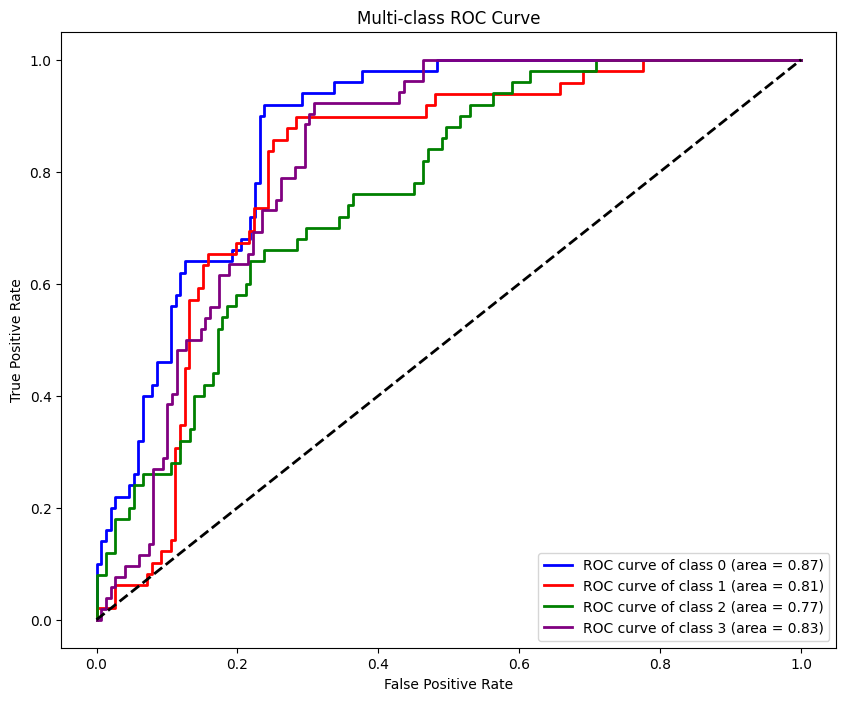

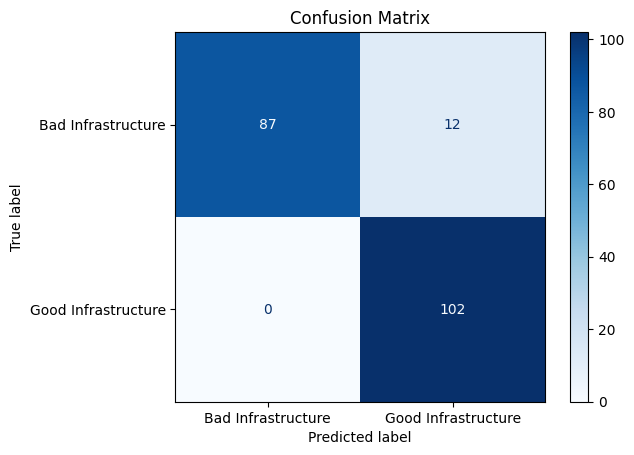


Classification Report:
                     precision    recall  f1-score   support

 Bad Infrastructure       1.00      0.88      0.94        99
Good Infrastructure       0.89      1.00      0.94       102

           accuracy                           0.94       201
          macro avg       0.95      0.94      0.94       201
       weighted avg       0.95      0.94      0.94       201



In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report
from itertools import cycle

def get_predictions_and_labels(generator, model):
    generator.reset()
    y_pred, y_true = [], []
    for X_batch, y_batch in generator:
        pred_batch = model.predict(X_batch, verbose=0)
        y_pred.append(pred_batch)
        y_true.append(y_batch)
        if len(y_pred) >= len(generator):
            break
    return np.vstack(y_pred), np.vstack(y_true)

print("Generating predictions for evaluation metrics...")
y_pred, y_true = get_predictions_and_labels(validation_generator, model)

# Multi-class ROC Curve
plt.figure(figsize=(10, 8))
fpr, tpr, roc_auc = {}, {}, {}
colors = cycle(['blue', 'red', 'green', 'purple'])
for i, color in zip(range(4), colors):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Convert to binary labels (0: Bad, 1: Good)
y_true_binary = np.where((y_true[:, 0] + y_true[:, 1]) > 0, 0, 1)
y_pred_binary = np.where((y_pred[:, 2] + y_pred[:, 3]) > (y_pred[:, 0] + y_pred[:, 1]), 1, 0)

# Confusion Matrix for 2 combined classes
cm = confusion_matrix(y_true_binary, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bad Infrastructure', 'Good Infrastructure'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true_binary, y_pred_binary, target_names=['Bad Infrastructure', 'Good Infrastructure']))


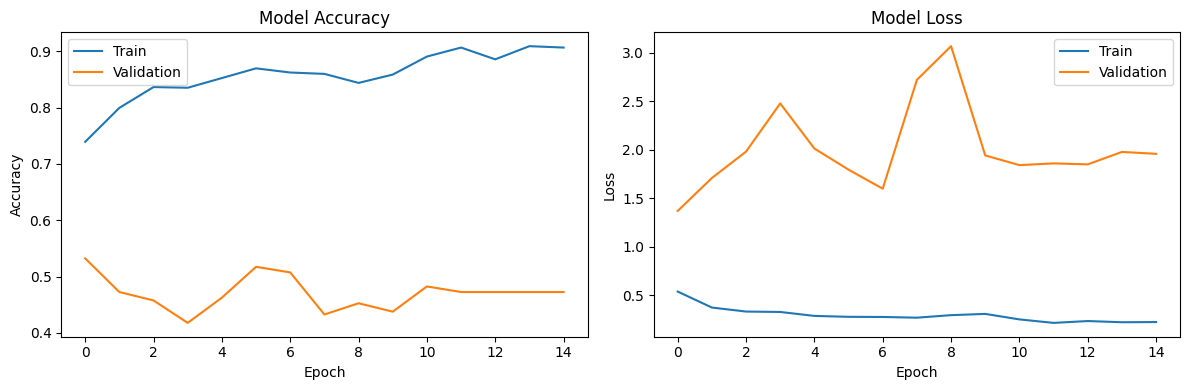

In [13]:

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'])
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()